In [15]:
import torch
torch.backends.cudnn.benchmark = True
from torchvision import transforms, utils
from util import *
from PIL import Image
import math
import random
import os

import numpy as np
from torch import nn, autograd, optim
from torch.nn import functional as F
from tqdm import tqdm
# import wandb
from model import *
from e4e_projection import projection as e4e_projection

from copy import deepcopy

In [16]:
os.makedirs('inversion_codes', exist_ok=True)
os.makedirs('style_images', exist_ok=True)
os.makedirs('style_images_aligned', exist_ok=True)
os.makedirs('models', exist_ok=True)

In [17]:
%matplotlib inline

device = 'cpu'
latent_dim = 512

trans = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

## Load model

In [22]:
# load original generator
original_generator = Generator(512, latent_dim, 8, 2).to(device)
# ckpt = torch.load('models/stylegan2-ffhq-config-f.pt', map_location=lambda storage, loc: storage)
# original_generator.load_state_dict(ckpt['g_ema'], strict=False)
mean_latent = original_generator.mean_latent(10000)

# to be finetuned generator
generator = deepcopy(original_generator)

## Align face

In [23]:
plt.rcParams['figure.dpi'] = 150

filename = 'chris_hemsworth.jpeg'
filepath = f'test_input/{filename}'

unaligned_face = trans(Image.open(filepath)).unsqueeze(0).to(device)
aligned_face = trans(align_face(filepath)).unsqueeze(0).to(device)

display_output = torch.cat([unaligned_face, aligned_face], 0)
display_image(utils.make_grid(display_output, normalize=True, range=(-1, 1)), title='Unaligned Face and Aligned Face')

ConnectionError: HTTPSConnectionPool(host='drive.google.com', port=443): Max retries exceeded with url: /uc?id=11BDmNKS1zxSZxkgsEvQoKgFd8J264jKp (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x7fdb76059dc0>: Failed to establish a new connection: [Errno 110] Connection timed out'))

## Inference with pretrained model

In [ ]:
# GAN inversion
sample_path = strip_path_extension(filename) + '.pt'
my_w = e4e_projection(align_face(filepath), sample_path, device).unsqueeze(0)

# Training has been completed, load pretrained model
pretrained = 'sketch_multi'
ckpt = f'{pretrained}.pt'

ckpt = torch.load(os.path.join('models', ckpt), map_location=lambda storage, loc: storage)
generator.load_state_dict(ckpt['g'], strict=False)

# Inference with finetuned StyleGAN
generator.eval()
with torch.no_grad():    
    my_sample = generator(my_w, input_is_latent=True)

# Display refence sample
style_path = f'style_images_aligned/sketch.png'
style_img = trans(Image.open(style_path)).unsqueeze(0).to(device)

my_output = torch.cat([style_img, aligned_face, my_sample], 0)
display_image(utils.make_grid(my_output, normalize=True, range=(-1, 1)), title='Inference with pretrained model')

KeyboardInterrupt: 

## Train our own style model (Disney Style) 

In [ ]:
my_style = 'disney'

alpha = 1.0
alpha = 1 - alpha

num_iter = 100

In [ ]:
# 1. GAN inversion
style_code_path = os.path.join('inversion_codes', f'{my_style}.pt')

style_img = os.path.join('style_images_aligned', f'{my_style}.png')
style_img_aligned = Image.open(style_img).convert('RGB')

latent = e4e_projection(style_img_aligned, style_code_path, device)
latents = [latent.to(device)]
latents = torch.stack(latents, 0)

FileNotFoundError: [Errno 2] No such file or directory: 'models/e4e_ffhq_encode.pt'

In [ ]:
#2. Form paired training dataset and finetune StyleGAN

# load discriminator
discriminator = Discriminator(1024, 2).eval().to(device)
ckpt = torch.load('models/stylegan2-ffhq-config-f.pt', map_location=lambda storage, loc: storage)
discriminator.load_state_dict(ckpt['d'], strict=False)

# reset generator
del generator
generator = deepcopy(original_generator)

g_optimizer = optim.Adam(generator.parameters(), lr=2e-3, betas=(0, 0.99))

idx_swap = list(range(7, generator.n_latent))

for idx in tqdm(range(num_iter)):
    mean_w = generator.get_latent(torch.randn([latents.size(0), latent_dim]).to(device)).unsqueeze(1).repeat(1, generator.n_latent, 1)
    in_latent = latents.clone()
    in_latent[:, idx_swap] = alpha * latents[:, idx_swap] + (1 - alpha) * mean_w[:, idx_swap]
    
    img = generator(in_latent, input_is_latent=True)
    
    targets = [trans(style_img_aligned).to(device)]
    targets = torch.stack(targets, 0)
    
    with torch.no_grad():
        real_feat = discriminator(targets)
    fake_feat = discriminator(img)
    loss = sum([F.l1_loss(a, b) for a, b in zip(fake_feat, real_feat)]) / len(fake_feat)
    
    g_optimizer.zero_grad()
    loss.backward()
    g_optimizer.step()

100%|████████████████████████████████████████████████████| 100/100 [00:18<00:00,  5.30it/s]


## Evaluate our model

/home/SENSETIME/shijianhan/.conda/envs/open_mmlab/lib/python3.7/site-packages/torchvision/utils.py:50: UserWarning: range will be deprecated, please use value_range instead.
  warnings.warn(warning)


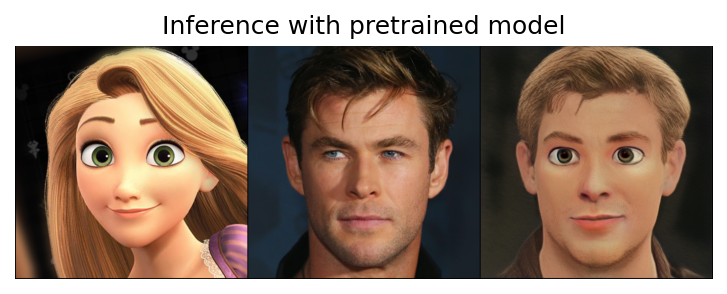

In [ ]:
generator.eval()
with torch.no_grad():
    my_disney_sample = generator(my_w, input_is_latent=True)
    
# Display refence sample
style_path = f'style_images_aligned/disney.png'
style_img = trans(Image.open(style_path)).unsqueeze(0).to(device)

my_output = torch.cat([style_img, aligned_face, my_disney_sample], 0)
display_image(utils.make_grid(my_output, normalize=True, range=(-1, 1)), title='Inference with pretrained model')